Import packages

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import scipy.linalg
import matplotlib.animation as ani
from matplotlib import rc
from IPython.display import HTML, Image
from matplotlib import cm
import scipy.integrate as integrate
rc('animation', html='jshtml')
plt.style.use('seaborn')

Set up space-time grid for the PDE. Create three different initial conditions that will form different shocks and plot

In [ ]:
def make_IC(a, b, n_x):
  # ramp function
  p0 = np.zeros((n_x//2,))
  p1 = np.array([i/(n_x/(b-a)) for i in range(n_x//(b-a) + 1)])
  p2 = np.array([1 for i in range(n_x//2 - n_x//(b-a))])
  u1 = np.concatenate((p0, p1, p2))
  # second ramp function
  p0 = np.ones((n_x//2,))
  p1 = np.array([1 - i/(n_x/(b-a)) for i in range(n_x//(b-a) + 1)])
  p2 = np.array([0 for i in range(n_x//2 - n_x//(b-a))])
  u2 = np.concatenate((p0, p1, p2))
  # step function
  u3 = [1-i//(n_x/2) for i in range(n_x)]

  return u1, u2, u3

h_x is: 0.1
h_t is: 0.1
Number of space cells: 100
Number of time cells: 100


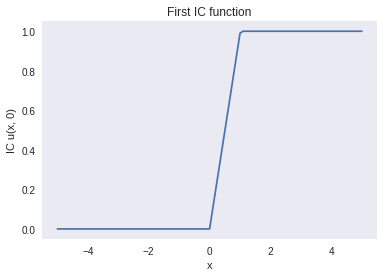

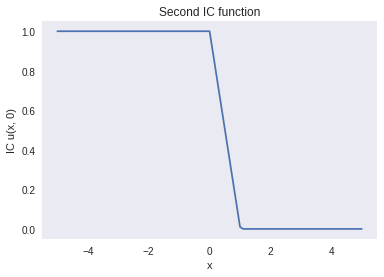

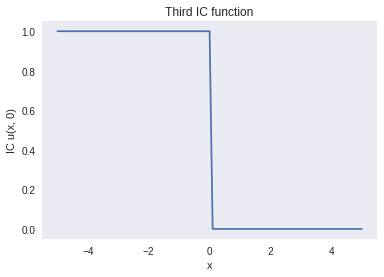

In [ ]:
n_x = 101 # grid points
n_t = 101 # grid points
n_space_cells = n_x - 1 # 100 space grid cells
n_time_cells = n_t - 1 # 100 time grid cells
a = -5
b = 5
T = 10
x = np.linspace(a, b, n_x)

# need to ensure that ht is less than hx for stability
hx = (b-a)/n_space_cells
ht = (b-a)/n_time_cells
print('h_x is: ' + str(hx))
print('h_t is: ' + str(ht))
print('Number of space cells: ' + str(n_space_cells))
print('Number of time cells: ' + str(n_time_cells))

u1, u2, u3 = make_IC(a, b, n_x)

plt.figure()
plt.plot(x, u1)
plt.xlabel('x')
plt.ylabel('IC u(x, 0)')
plt.title('First IC function')
plt.grid()

plt.figure()
plt.plot(x, u2)
plt.xlabel('x')
plt.ylabel('IC u(x, 0)')
plt.title('Second IC function')
plt.grid()

plt.figure()
plt.plot(x, u3)
plt.xlabel('x')
plt.ylabel('IC u(x, 0)')
plt.title('Third IC function')
plt.grid()

Plot the characteristics for these three initial conditions

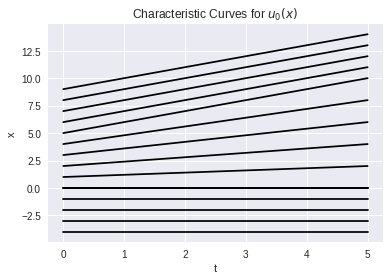

In [ ]:
t1 = np.linspace(0, T/2, n_t//2)
zeros = np.zeros((len(t1),))
for i in range(5):
  plt.plot(t1, zeros-i, 'k');
for i in range(5):
  plt.plot(t1, i*t1/5+i, 'k');
for i in range(5, 10):
  plt.plot(t1, t1+i, 'k');
plt.xlabel('t');
plt.ylabel('x');
plt.title('Characteristic Curves for $u_0(x)$');

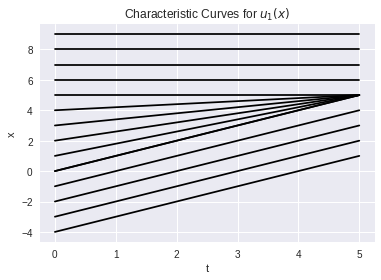

In [ ]:
t1 = np.linspace(0, T/2, n_t//2)
zeros = np.zeros((len(t1),))
for i in range(T//2):
  plt.plot(t1, t1-i, 'k');
for i in range(T//2):
  plt.plot(t1, (T/2-i)*t1/(T/2)+i, 'k');
for i in range(T//2, T):
  plt.plot(t1, zeros+i, 'k');
plt.xlabel('t');
plt.ylabel('x');
plt.title('Characteristic Curves for $u_1(x)$');

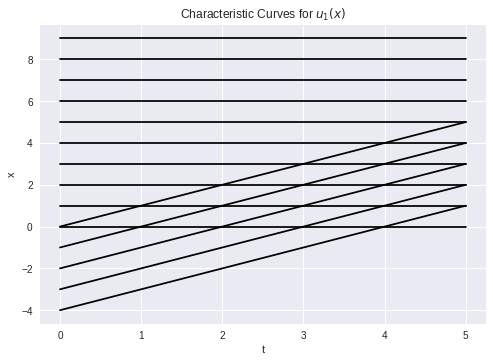

In [ ]:
t1 = np.linspace(0, T/2, n_t//2)
zeros = np.zeros((len(t1),))
for i in range(T//2):
  plt.plot(t1, t1-i, 'k');
for i in range(0, T):
  plt.plot(t1, zeros+i, 'k');
plt.xlabel('t');
plt.ylabel('x');
plt.title('Characteristic Curves for $u_2(x)$');

Now integrate over each cell to obtain the numerical approximation $v_{i,0}$ of the average over cell $i$ of $u_0(x)$, $v_{i,0} \approx u_{i,0} = \frac{1}{h_x}\int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}}u(x,0)dx$

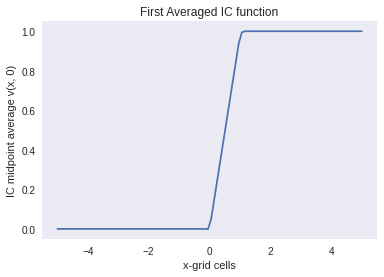

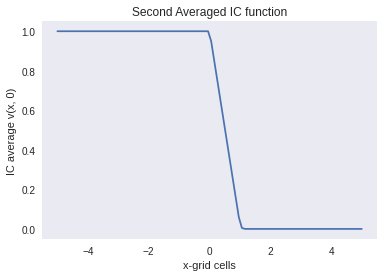

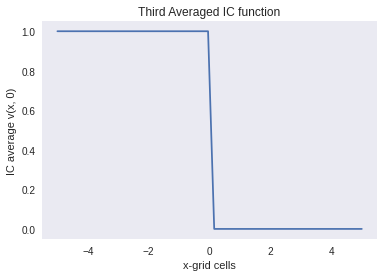

In [ ]:
# iterate over each cell and approximate the average value in each cell
v1_i0 = []
v2_i0 = []
v3_i0 = []

# everything here is linear, just average left and right points
for i in range(n_space_cells):
  v1_i0.append((u1[i]+u1[i+1])/2)
  v2_i0.append((u2[i]+u2[i+1])/2)
  v3_i0.append((u3[i]+u3[i+1])/2)

# plot the numerical approximations v1, v2, v3 at each space cell
plt.figure()
plt.plot(np.linspace(a, b, n_space_cells), v1_i0)
plt.xlabel('x-grid cells')
plt.ylabel('IC midpoint average v(x, 0)')
plt.title('First Averaged IC function')
plt.grid()

plt.figure()
plt.plot(np.linspace(a, b, n_space_cells), v2_i0)
plt.xlabel('x-grid cells')
plt.ylabel('IC average v(x, 0)')
plt.title('Second Averaged IC function')
plt.grid()

plt.figure()
plt.plot(np.linspace(a, b, n_space_cells), v3_i0)
plt.xlabel('x-grid cells')
plt.ylabel('IC average v(x, 0)')
plt.title('Third Averaged IC function')
plt.grid()

Now create the local Lax-Friedriechs flux function. The inputs to this function are the two approximations $v_{i,j}, v_{i+1,j}$ at a fixed time 

In [ ]:
def LF(v_i, v_i1):
  return (v_i**2 + v_i1**2)/4 - (v_i1-v_i)*abs(v_i+v_i1)/4

Iterate using a Finite Volumes approximation to the Inviscid Burger's equation $u_t+uu_x$ with the initial condition from 1a): $u_0(x) =    \left\{
\begin{array}{ll}
      0 & x\leq 0 \\
      x & 0\leq x\leq 1 \\
      1 & x\geq 1 \\
\end{array} 
\right.$

This initial condition does not generate shocks. The characteristics to the left of $x=0$ have slope zero and do not catch up to those to the right of $x=0$ which have positive slope, and therefore no collisions occur. We expect to see the solution to the left of $x=0$ remain zero for all time. To the right of $x=0$, the solution should decrease, as characteristics eminating from the region $0\leq x\leq 1$ propogate to the right.

In [ ]:
# create a matrix which will store the solutions on the grid at each time step
def FV_sol_to_burgers(v1_0, ht, hx, T, n_space_cells):
  S = np.zeros((n_time_cells, n_space_cells))

  t = ht
  count = 1
  v_j = v1_0
  S[0, :] = v_j

  while(t < T-ht):
    v_j1 = np.zeros((n_space_cells,))
    for i in range(1, n_space_cells-1):
      v_j1[i] = (-ht/hx)*(LF(v_j[i], v_j[i+1]) - LF(v_j[i-1], v_j[i])) + v_j[i]
    # now set the boundary values of v_j1[i] manually using characteristic information
    v_j1[0] = v1_0[0]
    v_j1[-1] = v1_0[-1]
    # store in the matrix
    S[count, :] = v_j1
    v_j = v_j1
    t += ht
    count += 1

  return S

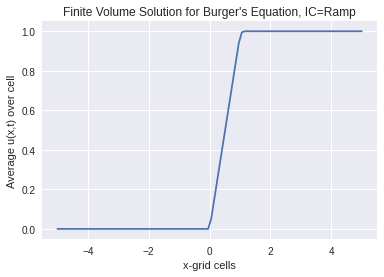

In [ ]:
S = FV_sol_to_burgers(v1_i0, ht, hx, T, n_space_cells)

fig = plt.figure()
def build_plot(i):
    plt.cla()
    if i < n_time_cells:
        plt.plot(np.linspace(a, b, n_space_cells), S[i, :])
        plt.grid(True)
        plt.ylabel('Average u(x,t) over cell')
        plt.xlabel('x-grid cells')
        plt.title('Finite Volume Solution for Burger\'s Equation, IC=Ramp')

ani.FuncAnimation(fig, build_plot)

View as a 3-D plot

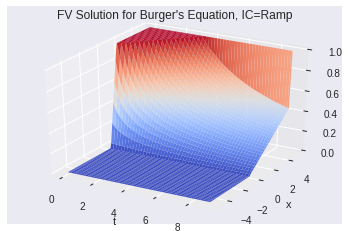

In [ ]:
X_grid = np.linspace(a, b, n_space_cells)
T_grid = np.linspace(0, T-1, n_time_cells)
X_grid, T_grid = np.meshgrid(X_grid, T_grid)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(T_grid, X_grid, S, cmap=cm.coolwarm)
plt.xlabel('t')
plt.ylabel('x')
plt.title('FV Solution for Burger\'s Equation, IC=Ramp');

The above plots show that the solution generated by Finite Volumes agrees with our analysis via characteristics. Indeed, the solutions remains zero to the right of $x=0$, and decreases appropriately to the right of $x=0$. We will do an error analysis below.

Iterate using a Finite Volumes approximation to the Inviscid Burger's equation $u_t+uu_x$ with the initial condition from 1b): $u_0(x) =    \left\{
\begin{array}{ll}
      1 & x\leq 0 \\
      1-x & 0\leq x\leq 1 \\
      0 & x\geq 1 \\
\end{array} 
\right.$

Unlike the function in 1a), this initial condition will generate a shock at $t=1$. This is because the function is decreasing, and characteristics eminating from the region $x \leq 1$ have larger slope and will catch up and collide with those eminating from the region $x \geq 1$.


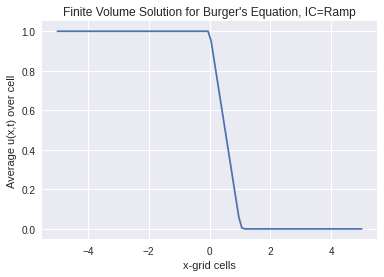

In [ ]:
S = FV_sol_to_burgers(v2_i0, ht, hx, T, n_space_cells)

fig = plt.figure()
def build_plot(i):
    plt.cla()
    if i < n_time_cells:
        plt.plot(np.linspace(a, b, n_space_cells), S[i, :])
        plt.grid(True)
        plt.ylabel('Average u(x,t) over cell')
        plt.xlabel('x-grid cells')
        plt.title('Finite Volume Solution for Burger\'s Equation, IC=Ramp')

ani.FuncAnimation(fig, build_plot)

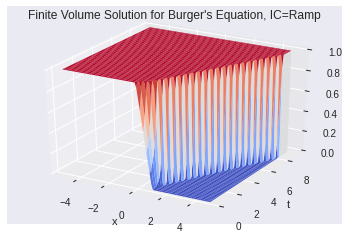

In [ ]:
X_grid = np.linspace(a, b, n_space_cells)
T_grid = np.linspace(0, T-1, n_time_cells)
X_grid, T_grid = np.meshgrid(X_grid, T_grid)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X_grid, T_grid, S, cmap=cm.coolwarm)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Finite Volume Solution for Burger\'s Equation, IC=Ramp');

Again, the above plots show that the solution generated by Finite Volumes agrees with our analysis via characteristics. We see that a shock soon forms after the simulation starts, and the discontinuity propogates to the right. Based on the analysis in question two, we expect the shock to travel at speed $s=\frac{u_l+u_r}{2}$. Since $u_l=1$ and $u_r=0$, the shock speed should be $s=\frac{1}{2}$.



Iterate using a Finite Volumes approximation to the Inviscid Burger's equation $u_t+uu_x$ with the initial condition from 2): 

$u_0(x) = \left\{
\begin{array}{ll}
      1 & x\leq 0 \\
      0 & x > 0 \\
\end{array} 
\right.$

This function has a discontinuity from the onset and so a shock forms at the origin in the $xt$ plane. Again, this is because the function is decreasing, and characteristics eminating from the region $x \leq 0$ have larger slope and will catch up and collide with those eminating from the region $x \geq 0$.

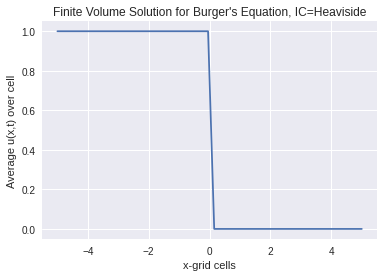

In [ ]:
S = FV_sol_to_burgers(v3_i0, ht, hx, T, n_space_cells)

fig = plt.figure()
def build_plot(i):
    plt.cla()
    if i < n_time_cells:
        plt.plot(np.linspace(a, b, n_space_cells), S[i, :])
        plt.grid(True)
        plt.ylabel('Average u(x,t) over cell')
        plt.xlabel('x-grid cells')
        plt.title('Finite Volume Solution for Burger\'s Equation, IC=Heaviside')

ani.FuncAnimation(fig, build_plot)

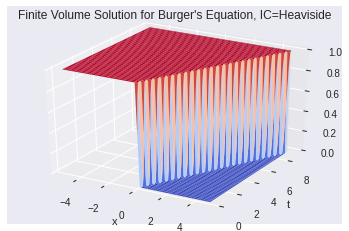

In [ ]:
X_grid = np.linspace(a, b, n_space_cells)
T_grid = np.linspace(0, T-1, n_time_cells)
X_grid, T_grid = np.meshgrid(X_grid, T_grid)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X_grid, T_grid, S, cmap=cm.coolwarm)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Finite Volume Solution for Burger\'s Equation, IC=Heaviside');

Again, the above plots show that the solution generated by Finite Volumes agrees with our analysis via characteristics. We see that a shock forms immediately as the simulation starts, and the discontinuity propogates to the right. Again, based on the analysis in question two, we expect the shock to travel at speed $s=\frac{u_l+u_r}{2}$. Since $u_l=1$ and $u_r=0$, the shock speed should be $s=\frac{1}{2}$. This is confirmed visually, as the shock travels 5 x-units in approximately 10 seconds for a shock speed $s=\frac{1}{2}$


## Verify that the errors are $O(h_x)$ for $u_0(x) = \left\{
\begin{array}{ll}
      1 & x\leq 0 \\
      0 & x > 0 \\
\end{array} 
\right.$


First calculate the exact solution at $T=5$. Since the shock speed is $s=\frac{1}{2}$, at $T=5$ the shock will have traveled $2.5$ x-units to the right. Thus our solution on the interval $[-5,5]$ should be the step function $u(x) = \left\{
\begin{array}{ll}
      1 & x\leq 2.5 \\
      0 & x > 2.5 \\
\end{array} 
\right.$

Now set up various grid spacings and plot the difference between the Finite Volumes solution and the true solution calculated above. Make $h_t$ very small so that the CFL condition is satisfied throughout

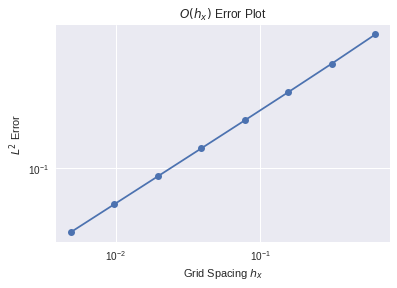

In [ ]:
n_x_array = np.array([(2**i)+1 for i in range(4, 12)])
n_t = (2**12)+1
n_space_cells_array = n_x_array - 1
n_time_cells = n_t - 1
a = -5
b = 5
T = 10
l2_errors = []

hx_array = (b-a)/n_space_cells_array
ht = (b-a)/n_time_cells

# now loop over the n_x_array and calculate the l2 norm of the difference
for i in range(len(n_x_array)):
  n_x = n_x_array[i]
  n_space_cells = n_space_cells_array[i]
  hx = hx_array[i]
  _, _, u3 = make_IC(a, b, n_x)

  # iterate over each cell and approximate the average value in each cell
  v3_i0 = []

  # everything here is linear, just average left and right points
  for j in range(n_space_cells):
    v3_i0.append((u3[j]+u3[j+1])/2)

  S3 = FV_sol_to_burgers(v3_i0, ht, hx, T, n_space_cells)

  # the exact solution at time T=5 is a piecewise u(x,t) given above
  u_true = np.array([1 for i in range(n_space_cells)])

  # find the correct row of the solution matrix S corresponding to t=5
  ind = np.shape(S3)[0]//2
  u = S3[-2, :]
  x = np.linspace(a, b, n_space_cells)

  # calculate an l2 error
  l2_errors.append(np.sqrt(scipy.integrate.simps((u-u_true)**2, x)))

plt.plot((b-a)/n_space_cells_array, l2_errors, marker='o')
plt.xlabel('Grid Spacing $h_x$')
plt.ylabel('$L^2$ Error')
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.title('$O(h_x)$ Error Plot');

As we can see the $L^2$ error between the true solution computed via characteristics and the Finite Volume obeys the predicted linear $O(h_x)$. That is, as we halve the grid spacing $h_x$, the quantity $\sqrt{\int_{-5}^{5}(u_{FV}-u)^2}$ decreases by a constant multiple of one half.

This coupled with the visual confirmation above that the Finite Volume shock moves at the predicted speed $s=\frac{u_l+u_r}{2}=\frac{1}{2}$ is evidence that the simulation is behaving and implemented as it should be.